# Two-Stage Learning for Pushing: PPO Training + Diffusion Policy Cloning

    ROB 498: Robot Learning for Planning and Control (WN25) project.

## Colab Setup

    Note: modified to local setup.

### Setup Code 

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
# from google.colab import drive

# drive.mount('/content/drive')

In [3]:
import os
import sys

# GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
GOOGLE_DRIVE_PATH = r'/mnt/c/Users/hande/repos/ROB_498_Robot_Learning/upload_to_github/Two-Stage Learning for Pushing - PPO Training + Diffusion Policy Cloning'

files = os.listdir(GOOGLE_DRIVE_PATH)
expected_files = [ 'main.ipynb', 'panda_pushing_env.py', 'visualizers.py', 'pushing_rl.py', 
                  "learning_diffusion_policy.py", "diffusion_scheduler.py", "pushing_dp_training_data.npy"]

sys.path.append(GOOGLE_DRIVE_PATH)

# Verify that there are all the expected files in the directory
all_found = True
for expected_file in expected_files:
  if expected_file not in files:
    print(f'Required file {expected_file} not found!')
    all_found = False
if all_found:
  print('All required files are found :)')

All required files are found :)


In [4]:
# Install missing required packages 
# Unfortunately Colab does not have pybullet package by default, so we will have to install it every time that the notebook kernel is restarted.
# Install pybullet -- For simulation purposes
!pip install pybullet
# Install numpngw -- For visualization purposes
!pip install numpngw
# Install stable-baselines -- For RL implementations
!pip install stable-baselines3[extra]
!pip install shimmy>=2.0

In [5]:
import sys

!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install pybullet numpngw "stable-baselines3[extra]" "shimmy>=2.0"

In [6]:
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# Model-free Method for Planar Pushing

We will be applying model-free methods(RL and behavior cloning) to the planar block pushing task that you have seen in homeworks 3 and 5. 

1. Rather than implement your own RL algorithms, in this homework you will use [Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/). Stable-Baselines3 has implementations of a variety of different RL algorithms for you to use, and it is recommended that use these implementations rather than implement the RL algorithms yourself.

2. Then, we will collect a demonstration dataset with the trained RL policy (we will provide it for you) to train a diffusion policy. You will need to implement some key concepts in diffusion models.


# 1 - PPO on Object Pose Space:

In [7]:
from panda_pushing_env import PandaPushingEnv, TARGET_POSE, OBSTACLE_CENTRE, OBSTACLE_HALFDIMS, BOX_SIZE
from visualizers import NotebookVisualizer

from pushing_rl import *

pybullet build time: Oct 21 2025 11:20:22


## 1.1 - Obstacle Free Pushing
In this section you will implement a reward function for the RL algorithm for the case where there are no obstacles on the table. The reward function you choose is completely up to you. We will only evaluate the resulting policy on task performance. 

Some tips for your reward function
- In general dense rewards perform better than sparse rewards. A sparse reward is a reward that gives sparse signals, for example, a high reward for successfully completing the task. A dense reward gives signals at every timestep of the episode, for example, the distance to goal. 
- It is a good idea to combine a dense reward such as distance to goal with a large reward for task completion
- You may want to give a negative reward for task failure, such as the block leaving the allowable region. 

You should upload the trained policy to autograder. The autograder will run the policy 10 times and will pause if the policy succeeds once.

**TODO**:
* From `pushing_rl.py` edit the `obstacle_free_pushing_reward_function_object_pose_space`. The goal pose is `TARGET_POSE` which is a global variable

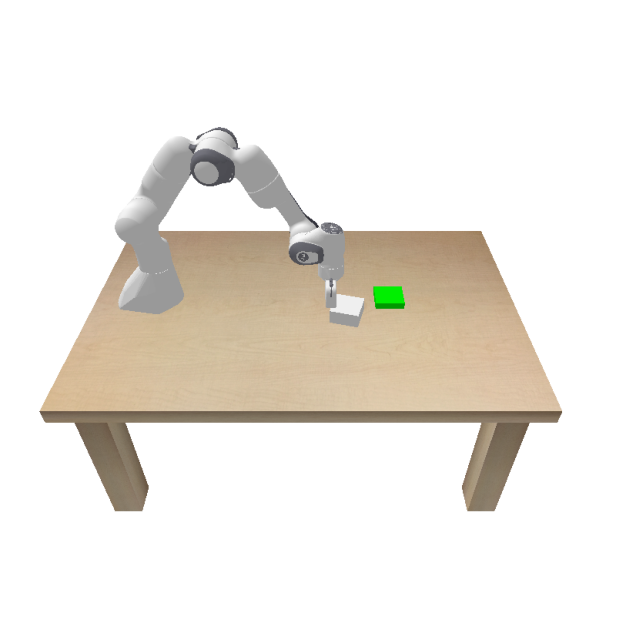

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.28s/it]

GOAL REACHED: False


In [11]:
%matplotlib inline

# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# Initialize the simulation environment having 'object_pose' as state space.
env = PandaPushingEnv(state_space='object_pose', 
                      reward_function=obstacle_free_pushing_reward_function_object_pose_space, 
                      visualizer=visualizer, 
                      render_non_push_motions=False,  
                      render_every_n_steps=3,
                      camera_heigh=800, 
                      camera_width=800)
env.reset()



# Perform a sequence of 3 random actions:
random_policy = RandomPolicy(env)

states, rewards, goal_reached = execute_policy(env, random_policy, num_steps=5)

plt.close(fig)
print(f'GOAL REACHED: {goal_reached}')
for state_i, reward_i in zip(states[1:], rewards):
    print(f'State {state_i} has a reward {reward_i}')

### Apply Stable Baselines:

In [12]:
import torch
print("cuda available?  ", torch.cuda.is_available())
print("CUDA devices #: ", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current device: ", torch.cuda.current_device())
    print("Device name:    ", torch.cuda.get_device_name(0))


cuda available?   True
CUDA devices #:  1
Current device:  0
Device name:     NVIDIA GeForce RTX 5070 Laptop GPU


In [13]:
print("Built with CUDA:", torch.version.cuda)


Built with CUDA: 12.8


In [14]:
total_timesteps = 5000 # may need to play with this number

env = PandaPushingEnv(state_space='object_pose',
                                reward_function=obstacle_free_pushing_reward_function_object_pose_space)
env.reset()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=total_timesteps, progress_bar=False)
model.save("free_pushing_object_pose")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/calmehan/miniconda3/envs/rob_599_robot_learning/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/home/calmehan/miniconda3/envs/rob_599_robot_learning/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.4     |
|    ep_rew_mean     | -34.9    |
| time/              |          |
|    fps             | 6        |
|    iterations      | 1        |
|    time_elapsed    | 293      |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 22.4        |
|    ep_rew_mean          | -21.8       |
| time/                   |             |
|    fps                  | 6           |
|    iterations           | 2           |
|    time_elapsed         | 586         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005967438 |
|    clip_fraction        | 0.0576      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.25       |
|    explained_variance   | 0.000885    |
|    learning_rate        | 0.

KeyboardInterrupt: 

**(Note: manually paused during a re-run. Code is fine)**

Visualize the learned policy performance:

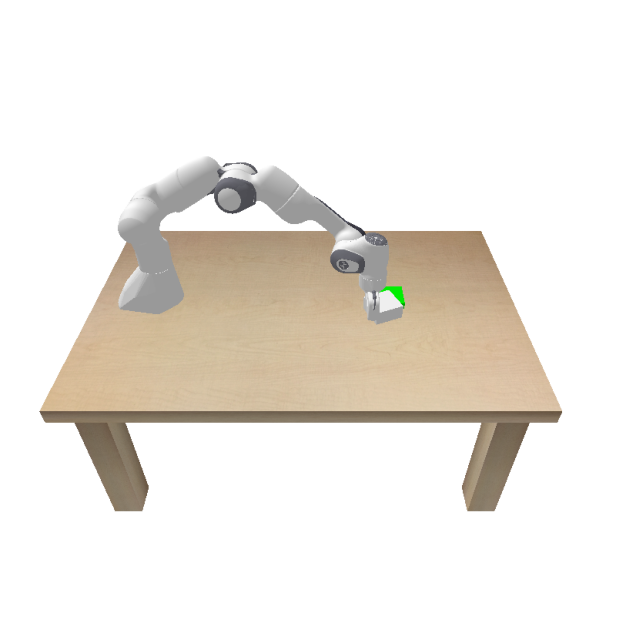

 65%|████████████████████████████████████████████████████▋                            | 26/40 [00:37<00:20,  1.46s/it]

GOAL REACHED: True


In [16]:
%matplotlib inline
model = PPO.load("free_pushing_object_pose_original")
# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)
env = PandaPushingEnv(state_space='object_pose', 
                      reward_function=obstacle_free_pushing_reward_function_object_pose_space, 
                      visualizer=visualizer, 
                      render_non_push_motions=False,  
                      camera_heigh=800, 
                      camera_width=800)
num_steps = 40

states, rewards, goal_reached = execute_policy(env, model, num_steps)
        
print(f'GOAL REACHED: {goal_reached}')

plt.close(fig)

# 2. Diffusion Policy

In this section, we will implement the state-of-the-art behavioral cloning method called Diffusion Policy, from the paper "Diffusion Policy: Visuomotor Policy Learning via Action Diffusion".
In this implementation, you will:
- Understand the core components of a diffusion-based policy
- Implement the forward diffusion process (adding noise to actions)
- Build the reverse diffusion process (denoising)
- Create the training loop for learning from demonstration data (collected by a RL policy)
- Learn how to sample actions from the trained policy

In [4]:
from learning_diffusion_policy import MultiStepDynamicsDataset, DiffusionPolicy ,normalize_data, unnormalize_data, save_diffusion_policy, load_diffusion_policy
from torch.utils.data import DataLoader
import collections
import pickle
import os
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

## 2.1 DDPM Noise Scheduler

The forward diffusion process gradually adds noise to the original data point $x_0$ through a series of steps. Let's first review how this process works and how it relates to the variables defined in `DDPMScheduler`.

### Forward Process Step by Step (t → t+1)

For each step in the forward process, we add a small amount of Gaussian noise according to the schedule defined by $\beta_t$. The process from time t to t+1 can be written as:

$x_{t+1} = \sqrt{\alpha_{t+1}}x_t + \sqrt{\beta_{t+1}}\epsilon_t$
where:
- $\beta_t$ is stored in `self.betas` (can be linear or cosine schedule)
- $\epsilon_t \sim \mathcal{N}(0, I)$ is random Gaussian noise
- $\alpha_t$ corresponds to `self.alphas` where `alphas = 1.0 - betas`

### Foward diffusion kernel (0 → t)

We can also express the forward process directly from $x_0$ to any timestep t using the accumulated product of $(1-\beta)$ terms:

$x_t = \sqrt{\bar{\alpha_t}}x_0 + \sqrt{1-\bar{\alpha_t}}\epsilon$

where:
- $\bar{\alpha_t} = \prod_{i=1}^t (1-\beta_i)$ is stored in `self.alphas_cumprod`
- $\sqrt{1-\bar{\alpha_t}}$ corresponds to `sqrt_one_minus_alpha_prod` 

### 2.1.1 Your Implementation Task:

In the `add_noise` method, you need to implement this forward process equation. You are given:
1. `original_samples`: $x_0$ with shape (B, H, D)
2. `noise`: $\epsilon$ with shape (B, H, D)
3. `timesteps`: t with shape (B,)

Steps to implement:
1. Calculate $\sqrt{\bar{\alpha_t}}$ and $\sqrt{1-\bar{\alpha_t}}$. Handle broadcasting: The coefficients need to be properly shaped to match the input dimensions
4. Compute the weighted sum according to the equation above


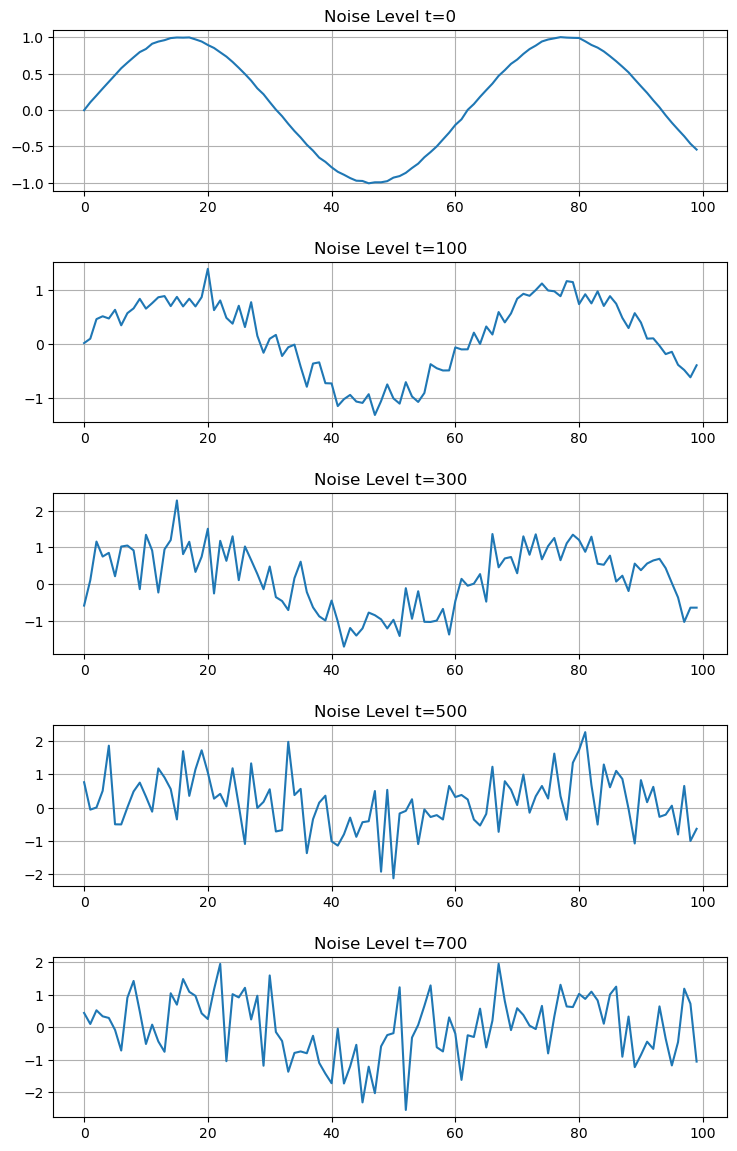

In [18]:
from diffusion_scheduler import DDPMScheduler

# Visualize the forward diffusion process
data = torch.sin(torch.linspace(0, 10, 100)).unsqueeze(-1).unsqueeze(0) # 1 x 100 x 1

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
timesteps = torch.tensor([0, 100,300, 500, 700, 999])
data = data.repeat(timesteps.shape[0], 1, 1)
noise = torch.randn_like(data)
noisy_data = noise_scheduler.add_noise(data, noise, timesteps)

fig, axes = plt.subplots(5, 1, figsize=(8, 12))
fig.tight_layout(pad=3.0)

for i, (t, ax) in enumerate(zip(timesteps, axes)):
    ax.plot(noisy_data[i].squeeze(-1))
    ax.set_title(f'Noise Level t={t}')
    ax.grid(True)

plt.show()


### 2.1.2 Reverse Diffusion Step

The reverse diffusion process (denoising) predicts $x_{t-1}$ from $x_t$ using the model's noise prediction. There are two ways to implement the one-step reverse process.

1. **Direct Approach** (one-step):
$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}}\epsilon_\theta(x_t, t)\right)$

2. **Two-Step Approach** (via $x_0$ prediction):
   - First predict $x_0$: $x_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} \left(x_t - \sqrt{1-\bar{\alpha}_t}\epsilon_\theta(x_t, t)\right)$
   - Then compute $x_{t-1}$ using predicted $x_0$ :
      $x_{t-1} = \frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1-\bar{\alpha}_t}x_0$

The two-step approach has several advantages:
1. **Guidance**: Having access to predicted $x_0$ allows us to implement classifier guidance or other modification techniques
2. **Debugging**: We can visualize the model's prediction of the clean sample at each step
3. **Quality Control**: We can apply constraints or corrections to the predicted $x_0$ before computing $x_{t-1}$

If you're interested in the derivation, please read https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#reverse-diffusion-process

### Your Implementation Task:
You will implement the Two-step approach in the `DDPMScheduler.step`
In the `step` method, you are given:
- `pred_noise`: predicted noise $\epsilon_\theta(x_t, t)$
- `timestep`: current timestep t
- `sample`: current noisy sample $x_t$

Steps to implement:
1. Predict $x_0$ following
 $x_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} \left(x_t - \sqrt{1-\bar{\alpha}_t}\epsilon_\theta(x_t, t)\right)$

2. Then compute coefficients for combining $x_0$ and $x_t$ following
      $x_{t-1} = \frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1-\bar{\alpha}_t}x_0$
   - Coefficient for $x_0$: `pred_original_sample_coeff`
   - Coefficient for $x_t$: `current_sample_coeff`

5. Finally combine them to get $x_{t-1}$:
   ```python
   pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * sample
   ```

Note: The variance term is already handled in the provided code, so you don't need to implement it.

In [19]:
from diffusion_scheduler import DDPMScheduler
data = torch.sin(torch.linspace(0, 10, 100)).unsqueeze(-1).unsqueeze(0) # 1 x 100 x 1
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
timesteps = torch.tensor([555])
prev_timestep = timesteps - 1
noise = torch.randn_like(data)
noisy_data = noise_scheduler.add_noise(data, noise, timesteps)
prev_noisy_data = noise_scheduler.add_noise(data, noise, prev_timestep)
prev_noisy_data_pred = noise_scheduler.step(noise, timesteps, noisy_data, add_noise=False)
print(torch.norm(prev_noisy_data -prev_noisy_data_pred)<0.1)

tensor(True)


## 2.2 Training and inference of diffusion policy


In this section, you will implement the training and sampling loop of a diffusion policy. The backbone model (1D UNet) and dataset have been provided for you.

### 2.2.1 Your Implementation Task:

In the `train_step` method, implement the training loop. You are given:
- `nobs`: normalized observations, shape (B, obs_horizon + 1, obs_dim)
- `naction`: normalized actions, shape (B, pred_horizon, action_dim)
- `obs_cond`: flattened observation condition, shape (B, obs_horizon * obs_dim)
- `self.noise_schedule`: DDPM scheduler for noise addition
- `self.model`: Conditional UNet1D model

Steps to implement:

1. Generate random noise:
2. Sample random timesteps for each item in batch:
3. Add noise to actions using the self.noise_schedule.add_noise:
4. Predict noise using the model:
   ```python
   noise_pred = self.model(noisy_actions, timesteps, global_cond=obs_cond)
   ```
5. Calculate MSE loss between predicted and actual noise:

Note: The optimizer step and learning rate scheduling are already handled after your implementation.

Key concepts:
- The model learns to predict the noise that was added to the actions
- We use random timesteps for each batch item to train on the full diffusion process
- The observation context (`obs_cond`) conditions the noise prediction

In [8]:
pred_horizon = 8
obs_horizon = 2
action_horizon = 4
train_data = np.load(os.path.join('pushing_dp_training_data.npy'), allow_pickle=True).item()
print(train_data["states"].shape)
dataset = MultiStepDynamicsDataset(train_data, pred_horizon=pred_horizon, obs_horizon=obs_horizon, action_horizon=action_horizon)
stats = dataset.stats
pickle.dump(stats, open('stats.pkl', 'wb'))
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
# visualize data in batch
batch = next(iter(dataloader))
print("batch['obs'].shape:", batch['states'].shape)
print("batch['action'].shape", batch['actions'].shape)
print(len(dataloader))

(100, 31, 3)
batch['obs'].shape: torch.Size([64, 3, 3])
batch['action'].shape torch.Size([64, 8, 3])
36


The model will take around 15-20 mins to train (on Google Colab with T4). If implemented properly, you should observe a loss around 0.3 after 1000 epochs. You may train it for longer time for better performance

In [21]:
obs_dim = 3
action_dim = 3
num_timesteps = 100 
diffusion_policy = DiffusionPolicy(
    obs_dim=obs_dim,
    action_dim=action_dim,
    obs_horizon=obs_horizon,
    pred_horizon=pred_horizon,
    action_horizon=action_horizon,
    num_timesteps=num_timesteps,
    device='cuda'
)

num_epochs = 1500
pbar = tqdm(range(num_epochs))
all_losses = []
for epoch in pbar:
    epoch_losses = []
    for batch in dataloader:
        loss = diffusion_policy.train_step(batch)
        epoch_losses.append(loss)
    epoch_loss = np.mean(epoch_losses)
    all_losses.append(epoch_loss)
    pbar.set_description(f'Train Loss: {epoch_loss:.4f}')

plt.plot(all_losses)
plt.show()


number of parameters: 1.041603e+06


Train Loss: 0.3460:  27%|███████████████▍                                          | 399/1500 [03:05<08:30,  2.16it/s]


KeyboardInterrupt: 

**(Note: manually paused during a re-run. Code is fine)**

In [26]:
# save the diffusion policy
save_diffusion_policy(diffusion_policy)


### 2.2.2 Implement the denoising loop

The prediction process reverses the diffusion process, starting from random noise and gradually denoising to generate actions. This is done by iteratively applying the reverse diffusion steps.

### Your Implementation Task:

In the `predict` method, implement the sampling process. You are given:
- `nstates`: normalized observation sequence, shape (obs_horizon, obs_dim)
- `self.model`: trained Conditional UNet1D model
- `self.noise_schedule`: DDPM scheduler for denoising steps
- `self.pred_horizon`: number of actions to predict
- `self.action_horizon`: number of actions to actually use
- `self.obs_horizon`: number of observations used for conditioning

Steps to implement:
1. Initialize the action with noise
2. Iterate over noise_schedule.timesteps. At each step, estimate the noise using diffusion policy and run one-step of reverse diffusion process.

Key concepts:
- The prediction starts from random noise and gradually denoises
- Each denoising step uses the model to predict the noise
- The observation context (`obs_cond`) conditions the generation process
- We generate more actions than needed (`pred_horizon`) but only use `action_horizon` steps
- The start index is `obs_horizon - 1` because that's when we want to start taking actions


Since we train the diffusion policy on a relatively small dataset, the expected success rate is around 50%.


In [1]:
from learning_diffusion_policy import MultiStepDynamicsDataset, DiffusionPolicy ,normalize_data, unnormalize_data, save_diffusion_policy, load_diffusion_policy
from torch.utils.data import DataLoader
import collections
import pickle
import os
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from panda_pushing_env import PandaPushingEnv, TARGET_POSE, OBSTACLE_CENTRE, OBSTACLE_HALFDIMS, BOX_SIZE
from visualizers import NotebookVisualizer
from pushing_rl import *

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
pybullet build time: Oct 21 2025 11:20:22


number of parameters: 1.041603e+06


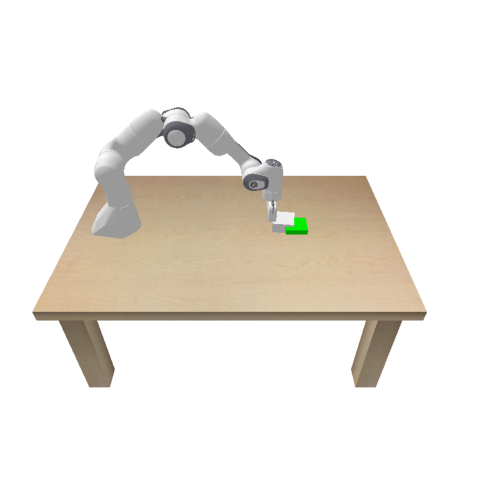

 73%|████████████████████████████████████████████████████████████▊                      | 22/30 [00:37<00:13,  1.69s/it]

GOAL REACHED: True
Avg goal reached: 1.0


In [9]:
%matplotlib inline
pred_horizon = 8
obs_horizon = 2
obs_dim = 3
action_dim = 3
num_timesteps = 100 
diffusion_policy, stats = load_diffusion_policy()
# Create the visualizer
fig = plt.figure(figsize=(6,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)
env = PandaPushingEnv(state_space='object_pose', 
                      reward_function=obstacle_free_pushing_reward_function_object_pose_space, 
                      visualizer=visualizer, 
                      render_non_push_motions=False,  
                      camera_heigh=800, 
                      camera_width=800)
num_steps = 30
trial = 1
goal_reached_list = []
for i in range(trial):
    state = env.reset()
    state_deque = collections.deque([state] * obs_horizon, maxlen=obs_horizon)
    goal_reached = False
    for i in tqdm(range(num_steps)):
        nstate_seq = np.stack(state_deque)
        nstates = normalize_data(nstate_seq, stats=stats['states'])
        nstates = torch.tensor(nstates).to(diffusion_policy.device)
        action_i = diffusion_policy.predict(nstates)
        action_i = unnormalize_data(action_i, stats=stats['actions'])
        state, reward, done, info = env.step(action_i[0])
        # Check if we have reached the goal
        end_pose = env.get_object_pos_planar()
        # Evaluate only position, not orientation
        goal_distance = np.linalg.norm(end_pose[:2] - TARGET_POSE[:2])  
        goal_reached = goal_distance < BOX_SIZE
        if done or goal_reached:
            break
    goal_reached_list.append(goal_reached)
    print(f'GOAL REACHED: {goal_reached}')

    plt.close(fig)
print("Avg goal reached:", np.mean(goal_reached_list))